In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

from scipy import ndimage
from sklearn import neighbors

In [2]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
dst = '../results/'

sample = 'D2'

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74


In [3]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
edt = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = edt < 2

edt = ndimage.distance_transform_cdt(wall, 'chessboard')
label, cellnum = ndimage.label(wall, struc1)
print('Detected',cellnum,'cells')

Detected 2937 cells


In [4]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
data = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
data.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(data.iloc[:,-1], return_index = False, return_inverse=True, return_counts=True) 
print(len(transcriptomes), 'transcriptomes')

targsort = np.argsort(tsize)[::-1]
for i in range(20):
    print(i+1, targsort[i], transcriptomes[targsort[i]], tsize[targsort[i]] , sep='\t')
print(data.shape)
data.iloc[:,:3].describe().drop(index='count').T.astype(dict(zip(['min','25%','50%','75%','max'], [int for i in range(5)])))

97 transcriptomes
1	2	BAC47034	1820064
2	85	GLYMA_17G195900	796880
3	26	GLYMA_05G092200	776841
4	7	BAC52602	121477
5	62	GLYMA_12G027400	53706
6	77	GLYMA_16G039800	37913
7	0	BAC45727	32613
8	57	GLYMA_11G008000	22998
9	28	GLYMA_05G216000	19464
10	84	GLYMA_17G185800	17018
11	25	GLYMA_05G023700	15123
12	74	GLYMA_15G210100	14368
13	16	GLYMA_02G003700	9003
14	27	GLYMA_05G203100	6415
15	30	GLYMA_06G065000	5477
16	47	GLYMA_09G127000	5108
17	31	GLYMA_06G090100	4916
18	22	GLYMA_04G063800	4625
19	10	CYP93A1	3929
20	24	GLYMA_04G227200	3687
(3830384, 4)


,mean,std,min,25%,50%,75%,max
X,9018.809175,3467.651045,3,6087,9157,11895,17146
Y,8152.751641,2937.713570,2,5718,8003,10380,17133
Z,28.216312,7.161211,1,23,28,33,61


In [24]:
tidx = 3
for tidx in range(len(transcriptomes)):
    tcoords = data.loc[invidx == tidx , ['X', 'Y', 'Z'] ].values.T
    nmask = ~nuclei[ tcoords[1], tcoords[0] ]
    coords = tcoords[:2, nmask]
    tlabs = label[coords[1], coords[0] ].astype(int)
    tpercell, _ = np.histogram(tlabs, np.arange(cellnum+2))
    print(tidx, transcriptomes[tidx], np.sum(nmask), len(nmask) - np.sum(nmask), np.round(100*np.sum(nmask)/len(nmask),1), sep='\t')

0	BAC45727	32171	442	98.6
1	BAC46169	1151	11	99.1
2	BAC47034	1795069	24995	98.6
3	BAC47856	1923	16	99.2
4	BAC48395	2985	48	98.4
5	BAC51072	2796	29	99.0
6	BAC51722	337	7	98.0
7	BAC52602	120280	1197	99.0
8	BAC52793	2412	41	98.3
9	BAC52805	1984	16	99.2
10	CYP93A1	3705	224	94.3
11	G4DT	523	52	91.0
12	GLYMA_01G019200	377	90	80.7
13	GLYMA_01G156200	445	32	93.3
14	GLYMA_01G164600	341	160	68.1
15	GLYMA_01G187400	600	23	96.3
16	GLYMA_02G003700	7666	1337	85.1
17	GLYMA_02G149100	73	17	81.1
18	GLYMA_02G201100	37	3	92.5
19	GLYMA_03G029900	86	1	98.9
20	GLYMA_03G079500	315	33	90.5
21	GLYMA_04G010600	24	0	100.0
22	GLYMA_04G063800	4611	14	99.7
23	GLYMA_04G208400	129	9	93.5
24	GLYMA_04G227200	3583	104	97.2
25	GLYMA_05G023700	14285	838	94.5
26	GLYMA_05G092200	764852	11989	98.5
27	GLYMA_05G203100	6153	262	95.9
28	GLYMA_05G216000	18398	1066	94.5
29	GLYMA_06G002000	751	254	74.7
30	GLYMA_06G065000	5451	26	99.5
31	GLYMA_06G090100	4682	234	95.2
32	GLYMA_06G168300	321	18	94.7
33	GLYMA_06G235500	118	47	71.5
34	G

In [30]:
tidx = 26

tcoords = data.loc[invidx == tidx , ['X', 'Y', 'Z'] ].values.T
nmask = ~nuclei[ tcoords[1], tcoords[0] ]
coords = tcoords[:2, nmask]
tlabs = label[coords[1], coords[0] ].astype(int)
tpercell, _ = np.histogram(tlabs, np.arange(cellnum+2))
print(transcriptomes[tidx], np.sum(nmask), len(nmask) - np.sum(nmask), np.round(100*np.sum(nmask)/len(nmask),1), sep='\t')

GLYMA_05G092200	764852	11989	98.5


# Deal with transcripts on the edge

In [31]:
def correct_boundary_transcripts(R = 25):
    for i in np.nonzero(tlabs == 0)[0]:
        x,y = coords[:,i]
        ss = np.s_[y - R : y + R, x - R : x + R]
        cells = np.unique(label[ss])[1:]
        newlab = cells[np.argmax(tpercell[cells])]
        com = np.flip(np.mean(np.asarray(np.nonzero(label[ss] == newlab)), axis=1))
        com[0] += x - R
        com[1] += y - R
        dv = com - coords[:,i]
        dv = dv/np.linalg.norm(dv)
        delta = 1
        x,y = (coords[:,i] + delta*dv).astype(int)
        
        while(label[y,x] != newlab) and (delta < 50):
            delta += 1
            x,y = (coords[:,i] + delta*dv).astype(int)
        if delta < 50:
            coords[:,i] = [x,y]
            tlabs[i] = newlab
        else:
            print('Review index', i)

    return 0

In [32]:
foo = np.sum(tlabs == 0)
print('Initially, there are\t',foo,'\ttranscripts on the walls',sep='')
print(np.nonzero(tlabs == 0)[0][:15])
if foo > 0:
    correct_boundary_transcripts(R=5)
    foo = np.sum(tlabs == 0)
    print('Now there are\t',foo,'\ttranscripts on the walls',sep='')

Initially, there are	11764	transcripts on the walls
[  87  206  302  314  439  738  875  969  997 1107 1372 1565 1566 1604
 1619]
Now there are	0	transcripts on the walls


In [33]:
i = 87
R = 5
x,y = coords[:,i]
print(x,y)
ss = np.s_[y - R : y + R, x - R : x + R]
cells = np.unique(label[ss])[1:]
print(cells, tpercell[cells], sep='\n')
newlab = cells[np.argmax(tpercell[cells])]
com = np.flip(np.mean(np.asarray(np.nonzero(label[ss] == newlab)), axis=1))
com[0] += x - R
com[1] += y - R
dv = com - coords[:,i]
dv = dv/np.linalg.norm(dv)
delta = 1
x,y = (coords[:,i] + delta*dv).astype(int)

while(label[y,x] != newlab) and (delta < 50):
    delta += 1
    x,y = (coords[:,i] + delta*dv).astype(int)
print(x,y,delta)

7924 2087
[ 1 49]
[4516   21]
7923 2086 1


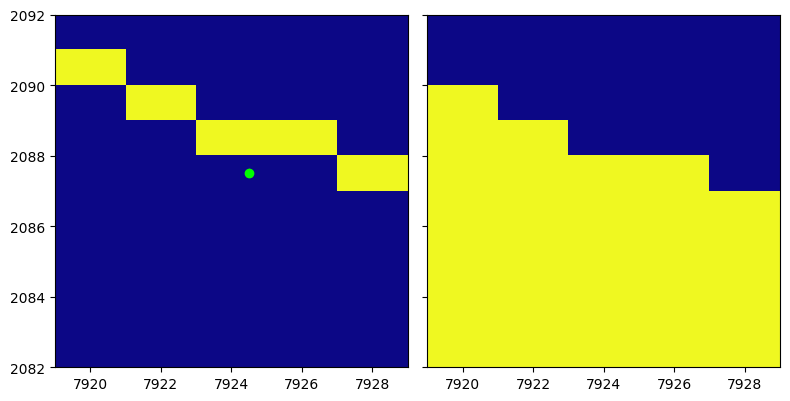

In [34]:
R = 5
x,y = coords[:,i]
ss = np.s_[y - R : y + R, x - R : x + R]

extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall[ss], cmap='plasma_r', origin='lower', extent=extent, vmin=0)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x+.5], [y+.5], c='lime', marker='o', zorder=4, alpha=1);

ax[1].imshow(label[ss]==newlab, cmap='plasma', origin='lower', extent=extent, vmin=0)

for j in range(len(ax)):
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

fig.tight_layout();

# Deal with misplaced transcripts

In [35]:
def transcript_shift(i, ndist, nidxs, cat, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals):
    mask = cdtlabs[nidxs[i]] == cat[i,1]
    nearest = np.average(cdtcoords[:,nidxs[i][mask]], axis=1, weights = radius - ndist[i][mask])
    dv = nearest - cdtcoords[:,edtvals[i]]
    dv = dv/np.linalg.norm(dv)
    x,y = cdtcoords[:,edtvals[i]]
    
    delta = 1
    x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
    while(label[y,x] != cat[i,1]) and (delta < radius):
        delta += 1
        x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
    if delta < radius:
        return [ [x,y], cat[i,1], True ]
    else:
        nearest = cdtcoords[:,nidxs[i][mask][0]]
        dv = nearest - cdtcoords[:,edtvals[i]]
        dv = dv/np.linalg.norm(dv)
        x,y = cdtcoords[:,edtvals[i]]
        
        delta = 1
        x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
        while(label[y,x] != cat[i,1]) and (delta < radius):
            delta += 1
            x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
        if delta < radius:
            return [ [x,y], cat[i,1], True ]
        else:
            return [ [x,y], cat[i,1], False ]

def get_neighbor_data(nidxs, indexing, minneighs, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals):
    
    cat = np.zeros((len(nidxs),4), dtype=int)

    for i in indexing:
        foo, bar = np.unique(cdtlabs[nidxs[i][1:]], return_counts=True)
        if len(foo) > 1:
            cts = bar/np.sum(bar)
            
            cat[i,0] = len(foo)
            cat[i,1] = foo[np.argmax(cts)]
            cat[i,2] = cat[i,1] != cdtlabs[edtvals[i]]
            cat[i,3] = 100*np.max(cts)
    
    return cat
            
def correct_shifted_transcripts(cdtlabs, cdtmask, cdtcoords, edtmask, edtvals, maxdwall=maxdwall, minneighs=minneighs, minprob = minprob):
    neigh = neighbors.NearestNeighbors(radius=radius)
    neigh.fit(cdtcoords.T)
    
    ndist, nidxs = neigh.radius_neighbors(cdtcoords[:, edtmask].T, sort_results=True)
    nneighs = np.array(list(map(len,nidxs))) - 1
    indexing = np.nonzero(nneighs > minneighs)[0]

    cat = get_neighbor_data(nidxs, indexing, minneighs, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals)
    
    indexing = np.nonzero((cat[:,2] == 1) & (cat[:,3] > 70))[0]
    for i in indexing:
        shift = transcript_shift(i, ndist, nidxs, cat, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals)
        if shift[2]:
            cdtcoords[:,edtvals[i]], cdtlabs[edtvals[i]] = shift[0], shift[1]
        else:
            print('Pay attention to index\t',i)

    return len(indexing)
    #return ndist, nidxs, cat

In [36]:
foo = 100
iters = 0

cdtmask = np.nonzero(edt[coords[1], coords[0]] < radius)[0]
if np.sum(cdtmask) > 0:
    cdtlabs = tlabs[cdtmask].copy()
    cdtcoords = coords[ :,  cdtmask].copy()
    edtmask = edt[cdtcoords[1], cdtcoords[0]] < maxdwall
    if np.sum(edtmask) > 0:
        edtvals = np.nonzero(edtmask)[0]
    
        while (foo  > 0) and (iters < 20):
            iters += 1    
            foo = correct_shifted_transcripts(cdtlabs, cdtmask, cdtcoords, edtmask, edtvals, maxdwall, minneighs, minprob)
            print('Iteration: ', iters, '\tShifted\t',foo,' transcripts', sep='')
        
        shiftmask = np.any(cdtcoords != coords[ :,  cdtmask], axis=0)
        print('Shifted\t',np.sum(shiftmask),'\ttranscripts in total', sep='')
print(np.nonzero(shiftmask)[0][:20])

Iteration: 1	Shifted	5772 transcripts
Iteration: 2	Shifted	1734 transcripts
Iteration: 3	Shifted	523 transcripts
Iteration: 4	Shifted	154 transcripts
Iteration: 5	Shifted	46 transcripts
Iteration: 6	Shifted	12 transcripts
Iteration: 7	Shifted	1 transcripts
Iteration: 8	Shifted	0 transcripts
Shifted	8242	transcripts in total
[   7   65  121  180  396  608  617  693  714  735  766  810  882  982
  994 1034 1063 1103 1109 1160]


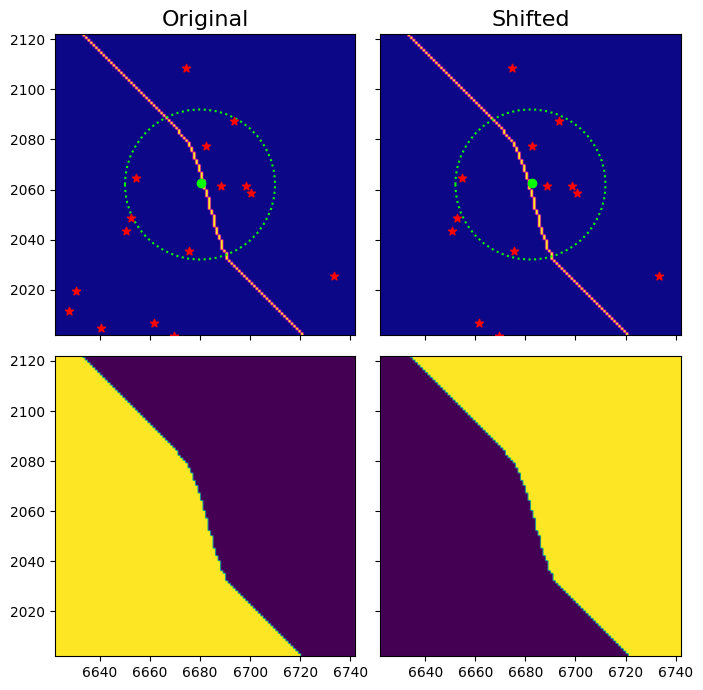

In [37]:
i = 7

R = radius*2
x,y = cdtcoords[:,i]
ss = np.s_[y - R : y + R, x - R : x + R]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); fs = 16

for j in [0,1]:
    ax[j].imshow(wall[ss], cmap='plasma_r', origin='lower', extent=extent)

x0,y0 = coords[:, cdtmask][:,i]
ax[0].set_title('Original', fontsize=fs)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x0+.5], [y0+.5], c='lime', marker='o', zorder=4, alpha=1);
ax[0].plot(radius*np.cos(theta)+x0, radius*np.sin(theta)+y0, c='lime', ls=':')

ax[1].set_title('Shifted', fontsize=fs)
ax[1].scatter(cdtcoords[0]+0.5, cdtcoords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[1].scatter([x+.5], [y+.5], c='lime', marker='o', zorder=4, alpha=1);
ax[1].plot(radius*np.cos(theta)+x, radius*np.sin(theta)+y, c='lime', ls=':')


ax[2].imshow(label[ss] == tlabs[cdtmask][i], origin='lower', extent=extent);
ax[3].imshow(label[ss] == cdtlabs[i], origin='lower', extent=extent);

for j in range(len(ax)):
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

fig.tight_layout();

# Save Results

In [38]:
print(coords.shape, tlabs.shape, cdtlabs.shape, cdtcoords.shape, nmask.shape, sep='\t')

(2, 764852)	(764852,)	(624068,)	(2, 624068)	(776841,)


In [39]:
np.sum(nuclei[cdtcoords[1], cdtcoords[0]])

7

In [40]:
coords = coords[:, ~nuclei[coords[1], coords[0]]]

In [41]:
filename = '../translocs/' + sample + '/location_corrected_' + sample +'_' + transcriptomes[tidx] + '.csv'
print(filename)
df = pd.DataFrame(coords.T)
df['foo'] = transcriptomes[tidx]
df.to_csv(filename, header=False, index=False)

../translocs/D2/location_corrected_D2_GLYMA_05G092200.csv


In [42]:
df.shape

(764847, 3)

# Scratch code 

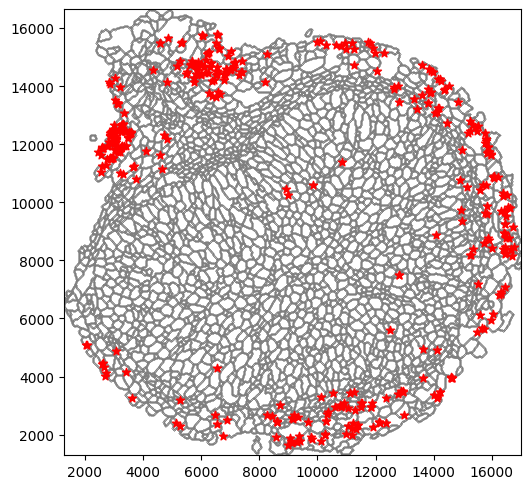

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.1, alpha=0.1)
ax[0].scatter(coords[0,rmask], coords[1,rmask], c='r', marker='*', zorder=3, alpha=1);

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].margins(0)

fig.tight_layout();